<h1 style="font-size:30px;">Midlane detecion and Camera position calculation</h1> 

At a high level, the pipeline takes these steps:

* Create a threshold for lane lines
* Selecting Region of Interest
* Detecting Edges using Canny Edge Detector
* Fit lines using Hough Line Transform
* Extrapolate the lanes from lines found
* Calculate the coordinate of midline of the lane 
* Calculate the distance between the middle point of the frame and the midline
* Composite the result original frame

## Table of Contents

1. [FUNCTIONS](#functions)
2. [Convert to grayscale and create a threshold for lane lines](#threshold)
3. [Selecting Region of Interest](#roi)
4. [Detecting Edges using Canny Edge Detector](#canny)
5. [Fit lines using Hough Line Transform](#hough)
6. [Extrapolate the lanes from lines found and Calculate the Midline](#extrapolate)
7. [Calculate the distance between the middle point of the frame and the midline](#distance)
8. [Composite the result original frame](#composite)
<a id='threshold'></a>

# I. FUNCTIONS
<a id='functions'></a>

Here is all the functions that we defined to process image in the our main function, **process_image()**

In [35]:
# Import libraries
import numpy as np
import cv2
from moviepy.editor import *
import matplotlib.pyplot as plt

In [69]:
def region_of_interest(img, vertices):
    """Select the region of interest (ROI) from a defined list of vertices."""
    # Create a blank mask image with the same size as the input image.
    mask = np.zeros_like(img)   
    
    # Define the color to fill the mask. It can be either a 3-channel or 1-channel color.
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # 3 or 4 depending on your image.
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Fill in pixels inside the polygon defined by the vertices.
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Apply the mask to the input image.
    masked_image = cv2.bitwise_and(img, mask)
    
    # Return the masked image.
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """Utility function for drawing lines on an image."""
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                # Draw a line on the image using the given color and thickness.
                cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """Utility function for defining line segments using the Hough transform."""
    # Detect line segments in the input image using the Hough transform.
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    if lines is not None:
        print("HOUGH yes")
        # Create a blank image to draw the detected line segments on.
        line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        # Draw the detected line segments on the blank image.
        draw_lines(line_img, lines)
        # Return the image with the detected line segments and the list of line segments.
        return line_img, lines
    
    # If no line segments are detected, return None.
    if lines is None:
        print('NO LINES')


def separate_left_right_lines(lines):
    """Separate the input lines into left and right lanes based on their slope."""
    left_lines = []
    right_lines = []
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                # Calculate the slope of the line.
                slope = (y1 - y2) / (x1 - x2)
                # Check if the slope is negative (left lane) or positive (right lane).
                if slope < 0:
                    left_lines.append([x1, y1, x2, y2])
                elif slope > 0:
                    right_lines.append([x1, y1, x2, y2])
    # Return the left and right lanes as separate lists.
    return left_lines, right_lines


def cal_avg(values):
    """Calculate the average of a list of values."""
    if values is None:
        return 0
    elif len(values) > 0:
        n = len(values)
        return sum(values) / n

def extrapolate_lines(lines, upper_border, lower_border):
    """Extrapolate lines keeping in mind the lower and upper border intersections.
    
    Args:
    - lines: a list of lines, each defined by four coordinates (x1, y1, x2, y2)
    - upper_border: the y-coordinate of the upper border of the region of interest (ROI)
    - lower_border: the y-coordinate of the lower border of the ROI
    
    Returns:
    - a list containing four coordinates (x1, y1, x2, y2) representing the extrapolated line
    """
    
    slopes = []  # list to store the slope of each line
    consts = []  # list to store the y-intercept of each line
    a = 0  # a counter
    
    # Loop through each line in the list of lines
    if (lines is not None) and (len(lines) != 0):
        for x1, y1, x2, y2 in lines:
            # If the line is vertical, add a small value to x2 to prevent division by zero
            if x1 == x2: 
                x2 = x2 + 1
            # Calculate the slope of the line
            slope = (y1-y2) / (x1-x2)
            # Add the slope to the list of slopes
            slopes.append(slope)
            # Calculate the y-intercept of the line
            c = y1 - slope * x1
            # Add the y-intercept to the list of y-intercepts
            consts.append(c)
                
        # Calculate the average slope and y-intercept
        avg_slope = cal_avg(slopes)
        avg_consts = cal_avg(consts)
        # If the average slope is zero, add a small value to prevent division by zero
        if avg_slope == 0: 
            avg_slope == avg_slope + 0.00001
        
        # Calculate the x-coordinate of the intersection of the extrapolated line with the lower border
        x_lane_lower_point = float((lower_border - avg_consts) / avg_slope)

        # Calculate the x-coordinate of the intersection of the extrapolated line with the upper border
        x_lane_upper_point = float((upper_border - avg_consts) / avg_slope)

        # Return the list of coordinates representing the extrapolated line
        return [x_lane_lower_point, lower_border, x_lane_upper_point, upper_border]
        
def extrapolated_lane_image(img, lines, roi_upper_border, roi_lower_border):
    """Main function called to get the final lane lines.
    
    Args:
    - img: the input image
    - lines: a list of lines, each defined by four coordinates (x1, y1, x2, y2)
    - roi_upper_border: the y-coordinate of the upper border of the region of interest (ROI)
    - roi_lower_border: the y-coordinate of the lower border of the ROI
    
    Returns:
    - lanes_img: a numpy array representing the final lane lines
    - mid_up: a tuple representing the upper midpoint of the lane
    - mid_down: a tuple representing the lower midpoint of the lane
    """
    
    # Create a blank image to store the final lane lines
    lanes_img = np.zeros((img.shape[0], img.shape[1], 3), dtype = np.uint8)
    
    # Separate the lines into left and right lanes
    lines_left, lines_right = separate_left_right_lines(lines)
    # Extract each lane.
    lines_left, lines_right = separate_left_right_lines(lines)
    lane_left = extrapolate_lines(lines_left, roi_upper_border, roi_lower_border)
    lane_right = extrapolate_lines(lines_right, roi_upper_border, roi_lower_border)

    # If both left and right lanes are detected
    if (lane_left is not None) and (lane_right is not None):
        # Draw the two lanes on the image
        draw_con(img, [[lane_left], [lane_right]])
        
        # Find the midpoint of the upper and lower lanes
        up_x = int((lane_left[2] + lane_right[2]) / 2)
        down_x = int((lane_left[0] + lane_right[0]) / 2)
        mid_up = (up_x, roi_upper_border)
        mid_down = (down_x,  roi_lower_border)
        
        # Draw the midline connecting the midpoint of the upper and lower lanes
        cv2.line(img, mid_up, mid_down, [0, 0, 255], 3)
        
    # If only one lane is detected or neither is detected
    if (lane_left is None) or (lane_right is None):
        # Use default midpoint values
        mid_up = (640, 361)
        mid_down = (645, 360)
        
    # Draw a line on the image using the given color and thickness.
    cv2.line(lanes_img, (int(lane_left[0]), int(lane_left[1])), (int(lane_left[2]), int(lane_left[3])), (255,0,0), 3)
    # Draw a line on the image using the given color and thickness.
    cv2.line(lanes_img, (int(lane_right[0]), int(lane_right[1])), (int(lane_right[2]), int(lane_right[3])), (255,0,0), 3)
    
    return lanes_img, mid_up, mid_down

def draw_con(img, lines):
    """Fill in lane area."""
    points = []
    for x1,y1,x2,y2 in lines[0]:
        points.append([x1,y1])
        points.append([x2,y2])
    for x1,y1,x2,y2 in lines[1]:
        points.append([x2,y2])
        points.append([x1,y1])
     
    points = np.array([points], dtype = 'int32')  
        
    cv2.fillPoly(img, points, (0,255,0))

def distance_from_center(mid_up, mid_down):
    # If mid_up or mid_down are None, set their values to the center of the image
    if (mid_up is None):
        mid_up = (640, 360)
    
    if (mid_down is None):
        mid_down = (640, 360)
    
    # If both mid_up and mid_down are not None, compute the distance between the midpoints
    if (mid_up is not None) and (mid_down is not None):
        # Compute the slope
        param = (mid_up[0] - mid_down[0])
        if(param == 0):
            param = param + 1
        else:
            m = (mid_up[1] - mid_down[1]) / param
            
            # Compute the y-intercept
            b = mid_up[1] - m * mid_up[0]

            # Compute the x-coordinate of the midpoint at the bottom of the image (where y = 480)
            mid_x = (480 - b) / m

            # Calculate the distance between the two midpoints in pixels
            dist_pixels = mid_x - 320

            # Calculate the distance between the two midpoints in millimeters using a conversion factor of 0.04285714 mm/pixel
            dist_mm = round(dist_pixels * 0.04285714 * 10, 3)
            
            # If the calculated distance is None, return None
            if dist_mm is None:
                return None
            
            # Otherwise, return the distance in millimeters
            return dist_mm, m

# II. Read Image, Convert to grayscale, Blur and Create a threshold for lane lines
<a id='threshold'></a>

In this step, we will create a threshold for detecting the lane lines. We will convert the image to grayscale and apply a threshold to it.

Text(0.5, 1.0, 'Threshold')

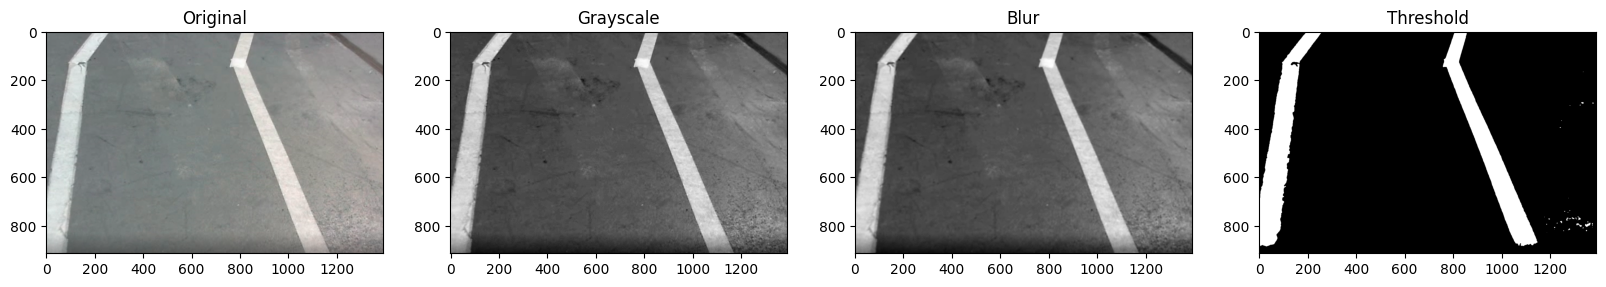

In [70]:
image = cv2.imread('D:\Spring-2023\Computer Vision\Assignment 1\TestingImage.png')
    
gray_select = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Remove noise using Gaussian blur.
kernel_size = 9
blur = cv2.GaussianBlur(gray_select, (kernel_size, kernel_size), 0)

# Use global threshold based on grayscale intensity.
threshold = cv2.inRange(blur, 180, 255)

# Display images.
plt.figure(figsize = (20, 10))
plt.subplot(1,4,1); plt.imshow(image, cmap = 'gray');        plt.title('Original')
plt.subplot(1,4,2); plt.imshow(gray_select, cmap = 'gray');  plt.title('Grayscale')
plt.subplot(1,4,3); plt.imshow(blur, cmap = 'gray');         plt.title('Blur')
plt.subplot(1,4,4); plt.imshow(threshold, cmap = 'gray');    plt.title('Threshold')

# III. Selecting Region of Interest
We will select the region of interest where we expect the lane lines to be present. We will mask out the unwanted parts of the image.

<a id='roi'></a>

Text(0.5, 1.0, 'ROI')

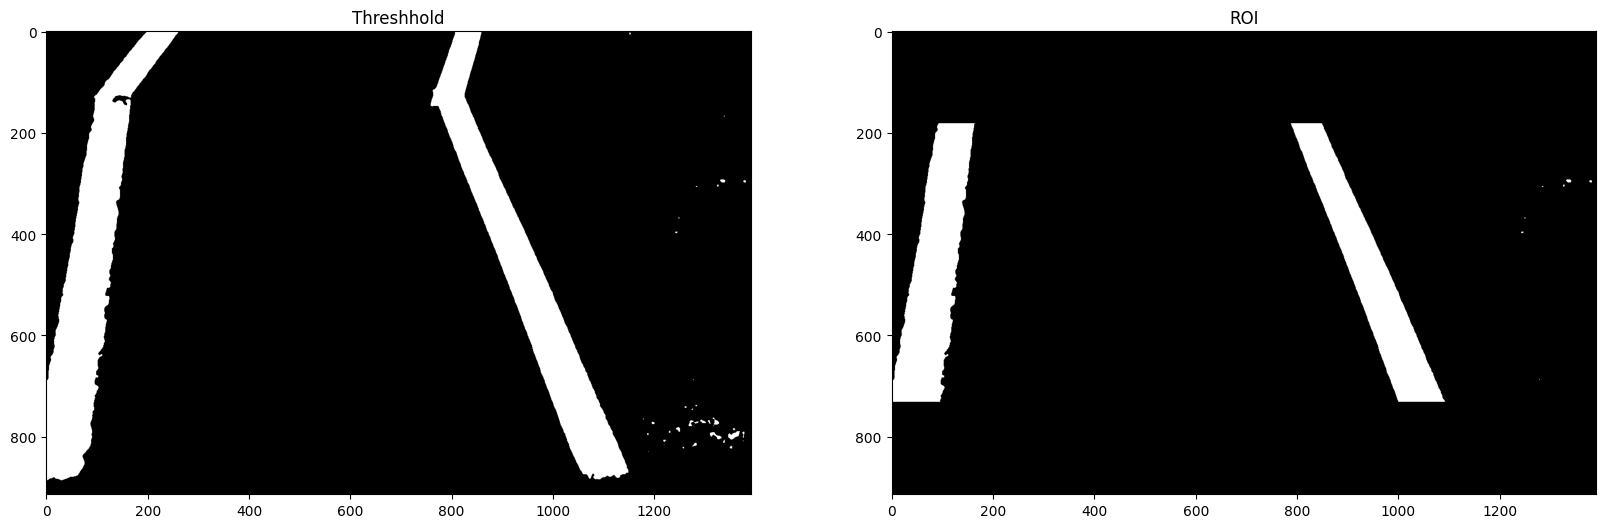

In [71]:
# Region masking: Select vertices according to the input image.
image_w = threshold.shape[1]
image_h = threshold.shape[0]

roi_vertices = np.array([[[0, 4*image_h/5],
                            [image_w, 4*image_h/5],
                            [image_w, image_h/5],
                            [0, image_h/5]]], dtype = np.int32)

gray_select_roi = region_of_interest(threshold, roi_vertices)

plt.figure(figsize = (20, 10))
plt.subplot(1,2,1); plt.imshow(threshold, cmap = 'gray');      plt.title('Threshhold')
plt.subplot(1,2,2); plt.imshow(gray_select_roi, cmap = 'gray');  plt.title('ROI')

# IV. Detecting Edges using Canny Edge Detector
We will apply the Canny Edge Detector to detect edges in the selected region of interest.

<a id='canny'></a>

Text(0.5, 1.0, 'Canny Edge Detection')

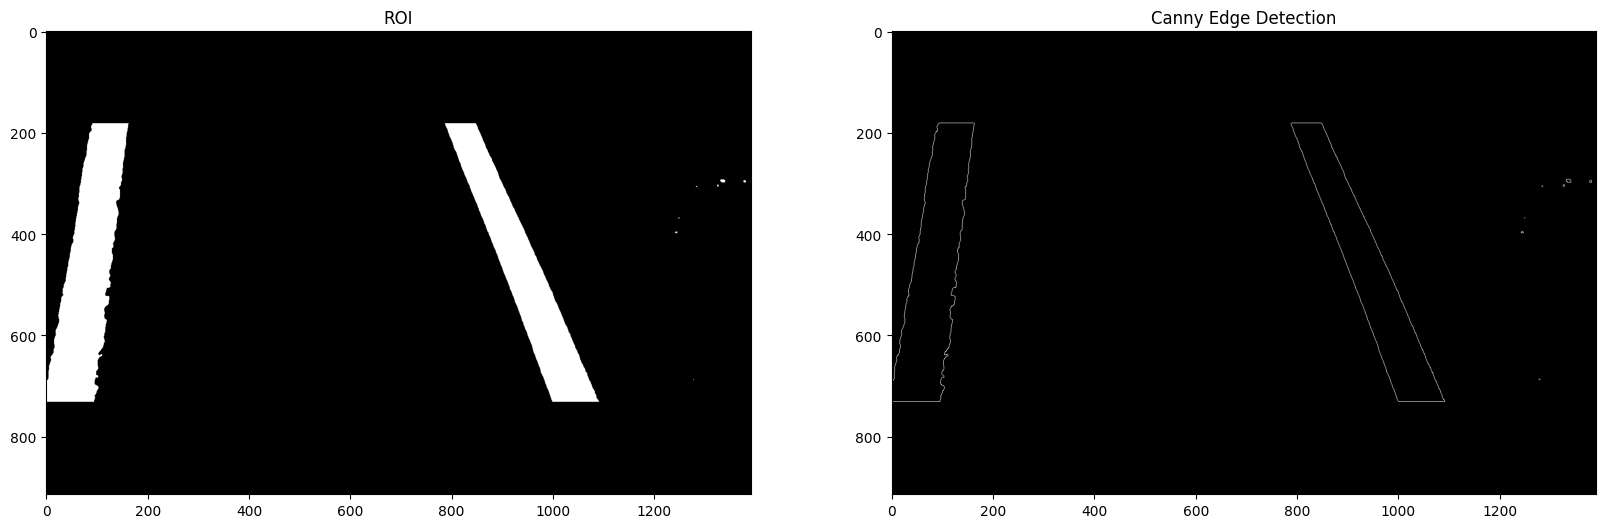

In [72]:
# Canny Edge Detection.
low_threshold = 50
high_threshold = 150
img_canny = cv2.Canny(gray_select_roi, low_threshold, high_threshold)

plt.figure(figsize = (20, 10))
plt.subplot(1,2,1); plt.imshow(gray_select_roi, cmap = 'gray');  plt.title('ROI')
plt.subplot(1,2,2); plt.imshow(img_canny, cmap = 'gray');        plt.title('Canny Edge Detection')

# V. Fit lines using Hough Line Transform
We will apply dilation on the image and use the Hough Line Transform to fit lines to the detected edges.

<a id='hough'></a>

HOUGH yes


Text(0.5, 1.0, 'Hough lines')

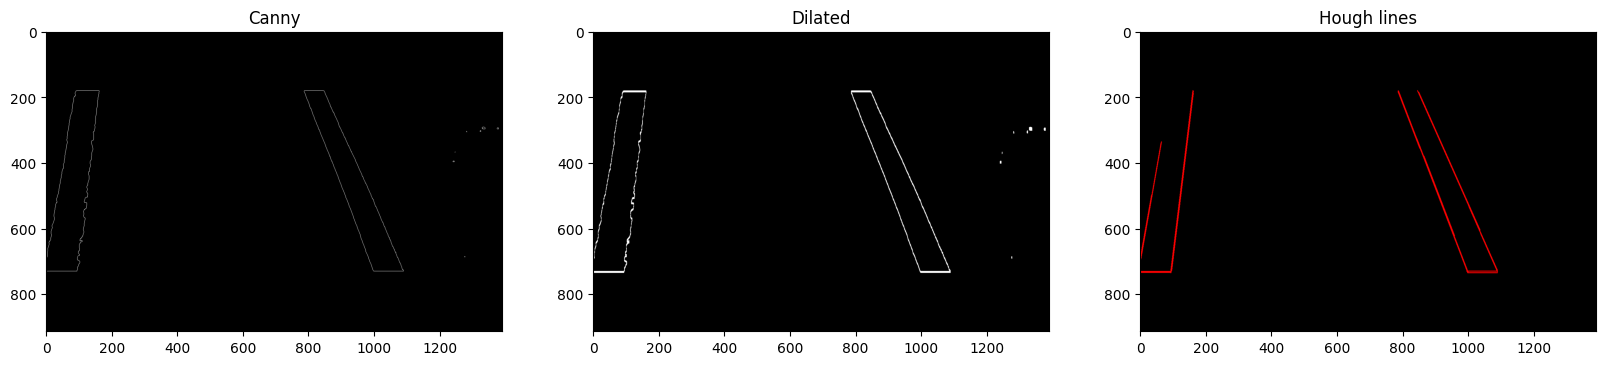

In [73]:
# Dilate edges to connect disconnected lines.
dilate = cv2.dilate(img_canny, (5,5) , iterations=5)

# Apply Hough transform to detect lines in the image.
rho = 1
theta = np.pi/180
threshold = 150
min_line_len = 1
max_line_gap = 100
hough, lines = hough_lines(dilate, rho, theta, threshold, min_line_len, max_line_gap)

# Display images.
plt.figure(figsize = (20, 10))
plt.subplot(1,3,1); plt.imshow(img_canny, cmap = 'gray'); plt.title('Canny')
plt.subplot(1,3,2); plt.imshow(dilate, cmap = 'gray');    plt.title('Dilated')
plt.subplot(1,3,3); plt.imshow(hough, cmap = 'gray');     plt.title('Hough lines')

# VI. Extrapolate the lanes from lines found
We will extrapolate the left and right lanes from the lines detected using the Hough Line Transform. In the **extrapolated_lane_image()** function, we also calculate the midline coordinate.

<a id='extrapolate'></a>

Coordinate of the first point of the mid line is:  (448, 0)
Coordinate of the end point of the mid line is:  (569, 914)


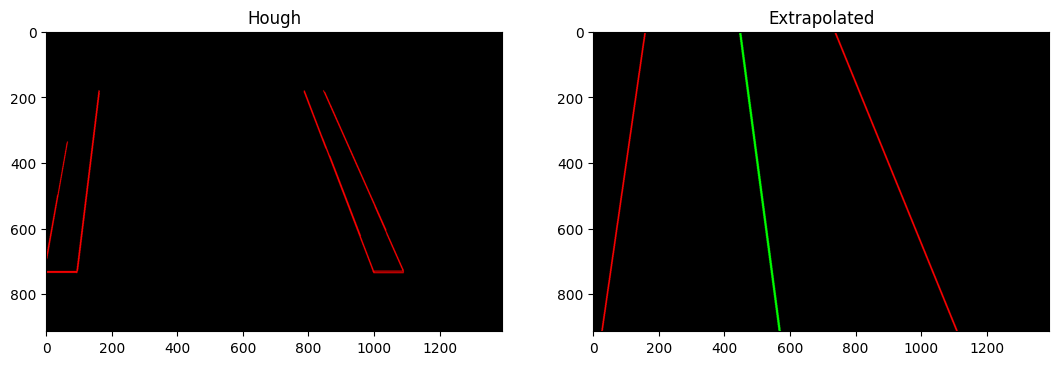

In [106]:
# Extrapolate detected lines to create lanes.
roi_upper_border = 0
roi_lower_border = image_h
lane_img, mid_up, mid_down = extrapolated_lane_image(image, lines, roi_upper_border, roi_lower_border)

cv2.line(lane_img, mid_up, mid_down, (0,255,0), 5)

# Display images.
plt.figure(figsize = (20, 10))
plt.subplot(1,3,1); plt.imshow(hough, cmap = 'gray');    plt.title('Hough')
plt.subplot(1,3,2); plt.imshow(lane_img, cmap = 'gray'); plt.title('Extrapolated')

# Print the Mid-line Coordinate
print("Coordinate of the first point of the mid line is: ", mid_up)
print("Coordinate of the end point of the mid line is: ", mid_down)

# VII. Calculate the distance between the middle point of the frame and the midline
We will calculate the distance between the middle point of the frame and the midline to determine the position of the vehicle with respect to the lane.

<a id='distance'></a>

Distance:  82.091
Slope:  7.553719008264463


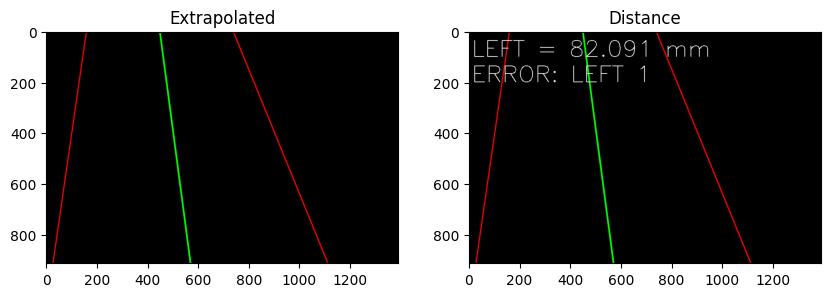

In [107]:
# Calculate distance of the lane from center and the slope of the mid line.
dist, m = distance_from_center(mid_up, mid_down)

plt.figure(figsize = (10,20))
plt.subplot(1,2,1); plt.imshow(lane_img, cmap = 'gray'); plt.title('Extrapolated')

# Display the distance from the center of the lane on the video feed.
if dist < 0 : 
    dist_mid = cv2.putText(lane_img, f"RIGHT = {-dist} mm", (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,255,255), 2)
elif dist > 0 : 
    dist_mid = cv2.putText(lane_img, f"LEFT = {dist} mm", (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,255,255), 2)
elif dist == 0 : 
    dist_mid = cv2.putText(lane_img, f"CENTER = {dist} mm", (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,255,255), 2) 
    
# Display the error from the center of the lane on the video feed.
if  15 < m <= 20 : 
    cv2.putText(lane_img, f"ERROR: LEFT 3", (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,255,255), 2)
elif 10 < m <= 15 : 
    cv2.putText(lane_img, f"ERROR: LEFT 2", (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,255,255), 2)
elif 2.5 < m <= 10 : 
    cv2.putText(lane_img, f"ERROR: LEFT 1", (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,255,255), 2)
elif -2.5 < m <= 2.5 : 
    cv2.putText(lane_img, f"ERROR: CENTER", (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,255,255), 2) 
elif -10 < m <= -2.5  : 
    cv2.putText(lane_img, f"ERROR: RIGHT 1", (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,255,255), 2)
elif -15 < m <= -10 : 
    cv2.putText(lane_img, f"ERROR: RIGHT 2", (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,255,255), 2) 
elif -15 < m <= -20 : 
    cv2.putText(lane_img, f"ERROR: RIGHT 3", (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,255,255), 2)

plt.subplot(1,2,2); plt.imshow(dist_mid, cmap = 'gray'); plt.title('Distance')

# Print the Mid-line Coordinate
print("Distance: ", dist)
print("Slope: ", m)

# VIII. Composite the result original frame
Finally, we will composite the result with the original frame and display the result.

<a id='composite'></a>

Text(0.5, 1.0, 'Result Image')

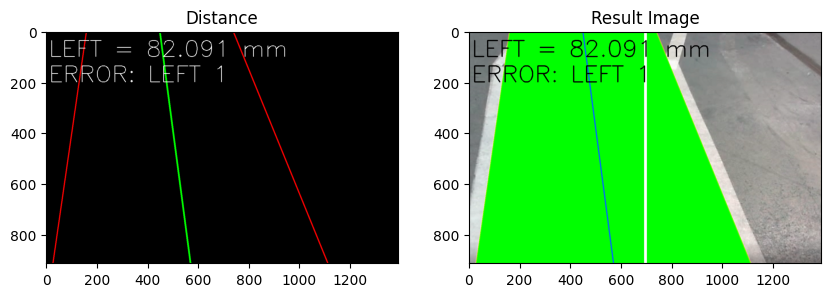

In [110]:
# Combine original image with lane image using weighted sum.
image_result = cv2.addWeighted(image, 1, lane_img, 0.4, 0.0)

# Draw a white line at the center of the image.
center_line = [[[image_w/2,0,image_w/2,image_h]]]
draw_lines(image_result, center_line, color = [255,255,255], thickness = 10)

# Display the distance from the center of the lane on the video feed.
if dist < 0 : 
    cv2.putText(image_result, f"RIGHT = {-dist} mm", (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,0), 4)
elif dist > 0 : 
    cv2.putText(image_result, f"LEFT = {dist} mm", (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,0), 4)
elif dist == 0 : 
    cv2.putText(image_result, f"CENTER = {dist} mm", (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,0), 4) 
    
# Display the error from the center of the lane on the video feed.
if  15 < m <= 20 : 
    cv2.putText(image_result, f"ERROR: LEFT 3", (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,0), 4)
elif 10 < m <= 15 : 
    cv2.putText(image_result, f"ERROR: LEFT 2", (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,0), 4)
elif 2.5 < m <= 10 : 
    cv2.putText(image_result, f"ERROR: LEFT 1", (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,0), 4)
elif -2.5 < m <= 2.5 : 
    cv2.putText(image_result, f"ERROR: CENTER", (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,0), 4) 
elif -10 < m <= -2.5  : 
    cv2.putText(image_result, f"ERROR: RIGHT 1", (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,0), 4)
elif -15 < m <= -10 : 
    cv2.putText(image_result, f"ERROR: RIGHT 2", (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,0), 4) 
elif -15 < m <= -20 : 
    cv2.putText(image_result, f"ERROR: RIGHT 3", (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,0), 4)

plt.figure(figsize = (10,20))
plt.subplot(1,2,1); plt.imshow(dist_mid, cmap = 'gray'); plt.title('Distance')
plt.subplot(1,2,2); plt.imshow(image_result, cmap = 'gray'); plt.title('Result Image')